# Suboptimal Compression
Inspect how much compression we get for each sequence when using suboptimal alignments.

In [1]:
import glob
import re

import numpy as np
import pandas as pd

from pqdm.threads import pqdm

In [2]:
def get_cluster_compression_dataframe(file: str):
    """
    Load the cluster file, get uniprot id, cluster membership and compression percentage for all sequences
    :param file:
    :return: pandas dataframe
    """
    cluster_id = re.search(r"/(cluster_[0-9]+).fasta", file).group(1)
    res = []
    cur_seq = None
    with open(file) as file_handler:
        for _line in file_handler:
            _line = _line.rstrip()
            if _line.startswith(">"):
                if cur_seq is not None:
                    res.append(cur_seq)
                cur_seq = {"uniprot_id": _line[1:], "cluster_id": cluster_id}
                continue
            cur_seq['suboptim_compress'] = np.round(_line.count('X') / len(_line), decimals=4)
    return pd.DataFrame(data=res)

In [3]:
df_update = pd.concat(pqdm(glob.glob('../data/suboptimal/masked_sequences/*.fasta'), get_cluster_compression_dataframe, n_jobs=10))

SUBMITTING | :   0%|          | 0/544 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/544 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/544 [00:00<?, ?it/s]

In [4]:
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    if 'suboptim_compress' in proteome_df:
        continue
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = proteome_df.merge(df_update, on="uniprot_id", how="left")
    proteome_df.to_csv(proteome_file)

### Visualize

In [2]:
from matplotlib import pyplot as plt

In [3]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [4]:
df.describe()

,seq_len,domain_count,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,suboptim_compress
count,1.087298e+06,545555.00000,1.087298e+06,1.087298e+06,1.087298e+06,1.087298e+06,1.075450e+06,513491.000000,1.056365e+06,1.056365e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,207722.000000
mean,4.064420e+02,1.11808,3.911778e+01,8.141461e+01,8.507000e+01,2.450463e-01,6.128500e+01,-0.311983,4.908758e-01,9.778296e-01,1.582429e-01,1.408789e-01,1.159461e-01,5.110148e-01,2.321597e-01,7.157321e+00,0.133778
std,6.549869e+02,12.27124,1.504080e+01,1.434268e+01,1.668829e+01,2.702486e-01,1.202969e+02,0.317159,4.024742e+00,4.935259e+00,6.244004e-02,4.279119e-02,3.881219e-02,7.133074e-02,5.411152e-02,1.922474e+00,0.101513
min,1.600000e+01,0.00000,1.390000e+00,2.307730e+01,2.217000e+01,0.000000e+00,0.000000e+00,-0.987435,0.000000e+00,0.000000e+00,3.044343e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.050000e+00,0.000000
25%,1.790000e+02,0.00000,2.785000e+01,7.301250e+01,8.187000e+01,3.530000e-02,2.271000e-01,-0.564031,0.000000e+00,0.000000e+00,1.139000e-01,1.172000e-01,9.420000e-02,4.683000e-01,1.977000e-01,5.506800e+00,0.054900
50%,3.130000e+02,0.00000,3.519000e+01,8.596510e+01,9.246000e+01,1.362000e-01,5.527000e-01,-0.345583,0.000000e+00,0.000000e+00,1.457000e-01,1.369000e-01,1.173000e-01,5.090000e-01,2.286000e-01,6.547900e+00,0.112800
75%,4.900000e+02,1.00000,4.652000e+01,9.291620e+01,9.639500e+01,3.718000e-01,7.707628e+01,-0.103957,0.000000e+00,1.000000e+00,1.881000e-01,1.584000e-01,1.380000e-01,5.510000e-01,2.615000e-01,8.933500e+00,0.194200
max,3.220000e+04,285.00000,9.738000e+01,9.875400e+01,9.887000e+01,1.000000e+00,2.730700e+03,0.918797,3.860000e+02,6.730000e+02,7.746000e-01,9.524000e-01,8.889000e-01,1.000000e+00,9.875000e-01,1.200000e+01,0.680400


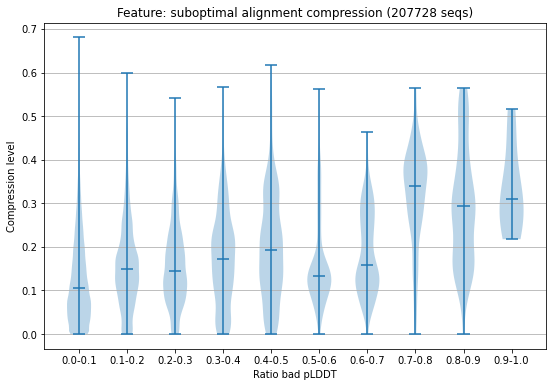

In [27]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(9, 6))

def violin_plot(ax, prop, title, bucket_step_size=0.1, decimals=1):
    xprop = 'ratio_bad_plddt'
    df_without_na = df.dropna(subset=[prop])
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')][prop].values for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    nans = [float('nan'), float('nan')]
    ax.violinplot(dataset=[bucket if bucket.any() else nans for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Ratio bad pLDDT')
    ax.set_ylabel(title)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

ax1.set_title('Feature: suboptimal alignment compression (207728 seqs)')
violin_plot(ax1, 'suboptim_compress', 'Compression level')

plt.show()

In [24]:
df_with_compression = df.dropna(subset=['suboptim_compress'])
df_with_compression.describe()

,seq_len,domain_count,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,suboptim_compress
count,207722.000000,0.0,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,0.0,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000
mean,318.702213,NaN,49.850257,92.106795,94.850678,0.051014,0.243523,NaN,0.017321,1.023358,0.151669,0.148860,0.121173,0.525955,0.204012,6.984032,0.133778
std,204.207274,NaN,15.983216,5.340511,4.675161,0.080520,0.113509,NaN,0.199432,6.780007,0.054939,0.050548,0.034825,0.062268,0.038356,2.089213,0.101513
min,20.000000,NaN,15.410000,34.501000,27.080000,0.000000,0.000100,NaN,0.000000,0.000000,0.042600,0.013500,0.000000,0.241400,0.016900,4.050000,0.000000
25%,166.000000,NaN,36.850000,90.097725,93.840000,0.006600,0.179700,NaN,0.000000,0.000000,0.111500,0.121300,0.104600,0.488800,0.179300,5.320200,0.054900
50%,285.000000,NaN,47.500000,93.499950,96.170000,0.024800,0.235900,NaN,0.000000,0.000000,0.141300,0.138900,0.124400,0.522400,0.202800,6.045900,0.112800
75%,420.000000,NaN,60.820000,95.641000,97.570000,0.064500,0.299400,NaN,0.000000,0.000000,0.180400,0.162600,0.142400,0.557400,0.227300,8.967400,0.194200
max,2463.000000,NaN,95.510000,98.739800,98.850000,0.971900,0.965300,NaN,45.000000,243.000000,0.488300,0.500000,0.383800,0.932200,0.421100,12.000000,0.680400


In [18]:
worst_entries = df_with_compression.sort_values(by=['ratio_bad_plddt', 'median_plddt'], ascending=[False, True]).head(n=300)
best_entries = df_with_compression.sort_values(by=['ratio_bad_plddt', 'median_plddt'], ascending=[True, False]).head(n=300)

In [19]:
worst_clusters = worst_entries['cluster_id'].value_counts()
best_clusters = best_entries['cluster_id'].value_counts()

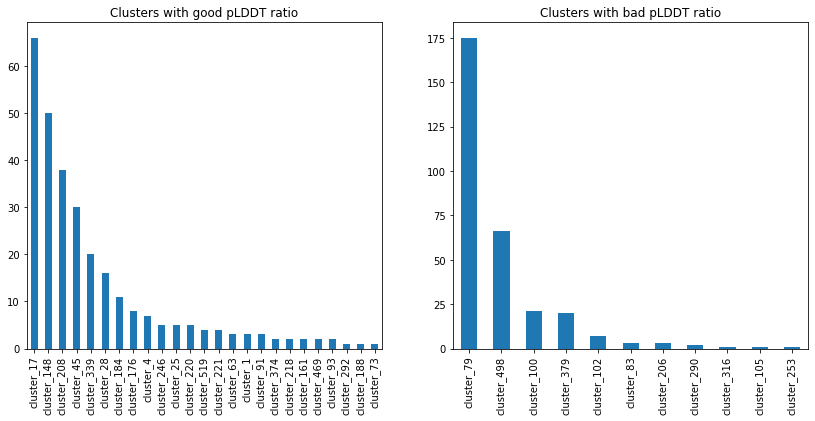

In [20]:
%matplotlib inline
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14, 6))

best_clusters[:25].plot(kind="bar", ax=ax1)
worst_clusters[:25].plot(kind="bar", ax=ax2)

ax1.set_title('Clusters with good pLDDT ratio')
ax2.set_title('Clusters with bad pLDDT ratio')

plt.show()

In [23]:
# Get some IDs for Vikram to investigate
worst_entries[['uniprot_id', 'ratio_bad_plddt', 'median_plddt', 'cluster_id']].to_csv('../data/interesting_sequences/bad_plddt_cluster_entries.csv', index=False)
best_entries[['uniprot_id', 'ratio_bad_plddt', 'median_plddt', 'cluster_id']].to_csv('../data/interesting_sequences/good_plddt_cluster_entries.csv', index=False)